In [1]:
import os
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)


# Host CPUs

# os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=16'

# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ", ".join(map(str, range(0, 1)))

jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=2, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=3, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=4, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=5, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=6, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=7, process_index=0, slice_index=0)]

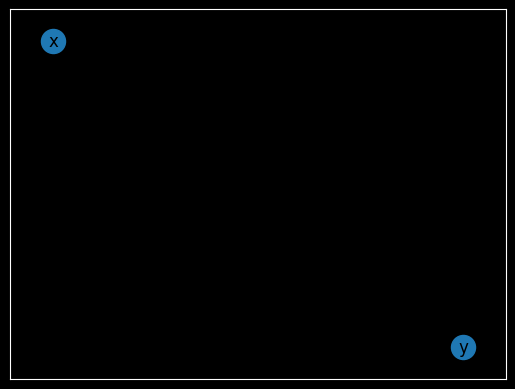

In [81]:
import dimod

import networkx as nx

from tabu import TabuSampler

from dwave.samplers import SteepestDescentSolver


# solver = SteepestDescentSolver()
solver = TabuSampler()

x, y = dimod.Binaries(['x', 'y'])

qubos = [x + y - 2.5 * x * y, 
         x + y + 2.5 * x * y]

graph = dimod.to_networkx_graph(qubos[1])

nx.draw_networkx(graph)

In [90]:
sampleset = solver.sample(qubos[1])

print(sampleset)

   x  y energy num_oc. num_re.
0  0  0    0.0       1       2
['BINARY', 1 rows, 1 samples, 2 variables]


In [114]:
qubo = {(0, 0): 1,
        (0, 1): -2,
        (1, 0): -2,
        (1, 1): 1}

qubo_2 = {(0, 0): 1,
          (0, 1): 2,
          (1, 0): 2,
          (1, 1): 1}

sampleset = solver.sample_qubo(Q=qubo_2)

print(sampleset)

   0  1 energy num_oc. num_re.
0  0  0    0.0       1       1
['BINARY', 1 rows, 1 samples, 2 variables]


In [103]:
def custom_sample(coefficient):
    
    # x + y - coefficient * x * y
    
    return coefficient

In [104]:
pmapped_sample = jax.pmap(
    custom_sample,
    # jitted_monte_carlo_mean,
    # static_broadcasted_argnums=(6, 7, 8),
    # in_axes=(None, None, None, None, None, 0, None, None, None, 0)
)

In [105]:
coefficients = jnp.array([[-2.5, 2.5]])

samples = pmapped_sample(coefficients)

print(samples)

[[-2.5  2.5]]
